# Chi-Square Estimator of Deep Parameters given Observed Placements

James Yu, 17 November 2021

In [1]:
using BlackBoxOptim, Distributions, ForwardDiff, JSON, Optim, Quadrature, StatsPlots
# may need to run import Pkg; Pkg.add("name_of_each_package") if using for the first time

This notebook contains a numerical global minimizer for the chi-squared metric of differences between a given set of job market placement rates and a set of theoretically-predicted rates given by values $v_i$ and offer distributions $F_i(x)$. This requires an existing allocation of Economics departments to type categories as given by the notebook on type allocations.

First, we use the same procedure as in the type allocations notebook to compile the matrix of observed placement rates between departments of different types. This takes from years 2015-2020 and, firstly, sorts placements into either those of Assistant Professorships or those to departments or sub-departments which do not graduate Ph.D. students.

In [2]:
INTERVAL = 2015:2020

year_by_year = JSON.parsefile("to_from_by_year.json")
sort(collect(keys(year_by_year)))
academic_builder = Set{}()
sink_builder = Set{}()
for key in INTERVAL
    data = year_by_year[string(key)]
    for aid in keys(data)
        outcome = data[aid]
        if outcome["position_name"] == "Assistant Professor"
            push!(academic_builder, outcome)
        else
            push!(sink_builder, outcome)
        end
    end
end
academic = Set{}()
academic_to = Set{}()
for outcome in academic_builder
    push!(academic, outcome["from_institution_name"])
    push!(academic_to, outcome["to_name"])
end
tch_sink = Set{}() # sink of teaching universities that do not graduate PhDs
for key in academic_to
    if !(key in academic)
        push!(tch_sink, key)
    end
end
filter_sink_builder = Set{}()
for outcome in sink_builder
    if outcome["from_institution_name"] in academic
        push!(filter_sink_builder, outcome)
    end
end
acd_sink = Set{}()
gov_sink = Set{}()
pri_sink = Set{}()
for outcome in filter_sink_builder
    if outcome["recruiter_type"] in [6, 7]
        # private sector: for and not for profit
        push!(pri_sink, string(outcome["to_name"], " (private sector)"))
    elseif outcome["recruiter_type"] == 5
        # government institution
        push!(gov_sink, string(outcome["to_name"], " (public sector)"))
    else
        # everything else including terminal academic positions
        push!(acd_sink, string(outcome["to_name"], " (academic sink)"))
    end
end
institutions = vcat(collect(academic), collect(acd_sink), collect(gov_sink), collect(pri_sink), collect(tch_sink))
out = zeros(UInt8, length(institutions), length(collect(academic)))
i = 0
for outcome in academic_builder
    i += 1
    out[findfirst(isequal(outcome["to_name"]), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end
for outcome in filter_sink_builder
    i += 1
    keycheck = ""
    if outcome["recruiter_type"] in [6, 7]
        keycheck = string(outcome["to_name"], " (private sector)")
    elseif outcome["recruiter_type"] == 5
        keycheck = string(outcome["to_name"], " (public sector)")
    else
        keycheck = string(outcome["to_name"], " (academic sink)")
    end
    out[findfirst(isequal(keycheck), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end

Next, we bring in the allocation from the type allocations notebook. This is a four-type allocation with one sink type that combines the individual sink positions from the previous step. The specific department names are provided in the type allocations notebook.

In [3]:
est_alloc = UInt8[0x04, 0x03, 0x01, 0x02, 0x03, 0x02, 0x03, 0x02, 0x01, 0x03, 0x01, 0x01, 0x03, 0x03, 0x03, 0x02, 0x03, 0x03, 0x03, 0x03, 0x02, 0x01, 0x01, 0x01, 0x01, 0x01, 0x03, 0x03, 0x01, 0x01, 0x03, 0x03, 0x04, 0x01, 0x03, 0x03, 0x03, 0x01, 0x01, 0x03, 0x03, 0x01, 0x03, 0x03, 0x03, 0x01, 0x01, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x01, 0x04, 0x03, 0x02, 0x03, 0x02, 0x04, 0x01, 0x01, 0x04, 0x03, 0x03, 0x03, 0x04, 0x01, 0x02, 0x02, 0x01, 0x03, 0x01, 0x01, 0x01, 0x03, 0x03, 0x01, 0x03, 0x03, 0x04, 0x02, 0x04, 0x04, 0x03, 0x03, 0x03, 0x02, 0x03, 0x04, 0x01, 0x01, 0x01, 0x01, 0x03, 0x03, 0x01, 0x03, 0x02, 0x01, 0x03, 0x04, 0x03, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x01, 0x03, 0x03, 0x04, 0x03, 0x03, 0x01, 0x01, 0x03, 0x03, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x01, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x02, 0x04, 0x03, 0x02, 0x02, 0x04, 0x03, 0x03, 0x03, 0x04, 0x03, 0x02, 0x04, 0x02, 0x01, 0x03, 0x03, 0x03, 0x02, 0x03, 0x02, 0x03, 0x03, 0x03, 0x03, 0x02, 0x03, 0x03, 0x01, 0x04, 0x01, 0x01, 0x03, 0x03, 0x01, 0x01, 0x03, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x03, 0x03, 0x03, 0x03, 0x04, 0x03, 0x03, 0x03, 0x03, 0x01, 0x04, 0x01, 0x02, 0x04, 0x03, 0x01, 0x01, 0x01, 0x04, 0x03, 0x02, 0x03, 0x03, 0x01, 0x03, 0x04, 0x03, 0x03, 0x02, 0x03, 0x03, 0x03, 0x01, 0x03, 0x03, 0x03, 0x03, 0x02, 0x01, 0x02, 0x03, 0x02, 0x03, 0x01, 0x03, 0x03, 0x03, 0x01, 0x03, 0x03, 0x02, 0x03, 0x03, 0x02, 0x01, 0x03, 0x03, 0x01, 0x03, 0x03, 0x03, 0x03, 0x02, 0x02, 0x03, 0x02, 0x01, 0x03, 0x03, 0x01, 0x03, 0x01, 0x02, 0x03, 0x02, 0x03, 0x01, 0x02, 0x04, 0x01, 0x01, 0x03, 0x04, 0x03, 0x03, 0x03, 0x03, 0x01, 0x02, 0x01, 0x01, 0x01, 0x03, 0x03, 0x03, 0x02, 0x01, 0x03, 0x03, 0x03, 0x03, 0x03, 0x02, 0x01, 0x01, 0x03, 0x03, 0x03, 0x01, 0x02, 0x03, 0x03, 0x01, 0x02, 0x03, 0x01, 0x03, 0x03, 0x02, 0x03, 0x01, 0x03, 0x02, 0x04, 0x03, 0x03, 0x04, 0x03, 0x03, 0x01, 0x02, 0x04, 0x02, 0x02, 0x01, 0x03, 0x02, 0x01, 0x01, 0x03, 0x01, 0x01, 0x01, 0x03, 0x04, 0x01, 0x01, 0x02, 0x02, 0x01, 0x03, 0x03, 0x01, 0x01, 0x03, 0x02, 0x03, 0x03, 0x01, 0x03, 0x02, 0x02, 0x03, 0x02, 0x02, 0x03, 0x04, 0x03, 0x01, 0x01, 0x03, 0x03, 0x01, 0x03, 0x02, 0x03, 0x03, 0x03, 0x04, 0x04, 0x02, 0x02, 0x03, 0x02, 0x01, 0x04, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05, 0x05];

The allocation combined with the individual department to department placements formulates the placement rate matrix.

In [4]:
function extract_T(assign, A, num)
    b = zeros(size(A)[1], size(A)[2])
    T = zeros(Int64, num + 1, num)

    # compute the placement rates
    for i in 1:size(A)[1], j in 1:size(A)[2]
         @inbounds T[(num + 1) * (assign[j] - 1) + assign[i]] += A[i, j]
    end
    
    return T
end

placement_rates_raw = extract_T(est_alloc, out, 4)
placement_rates_raw

5×4 Matrix{Int64}:
 118  163   41   363
  66  158   20   327
  84  168   94   255
  31   74   10   460
 433  757  165  1369

The matrix is then ordered such that, for any two elements in symmetric positions across the diagonal, the element below the diagonal is greater than the element above the diagonal. For example, the 204 in cell (1, 2) is greater than the 50 in the symmetric cell (2, 1) below, as are all the other symmetric pairs.

In [5]:
placement_rates = zeros(Int64, (5, 4))
order = [3 2 4 1 5]
for i in 1:5, j in 1:4
    placement_rates[order[i], order[j]] = placement_rates_raw[i, j]
end
placement_rates

5×4 Matrix{Int64}:
  460   74   31   10
  327  158   66   20
  363  163  118   41
  255  168   84   94
 1369  757  433  165

To estimate the number of positions $n_i$ across all departments, we take the total number of positions as $n = 3068$ derived from there being 1909 distinct hiring organizations on EconJobMarket from 2015-2020 who each hired on average 1.6 applicants, for $1909 * 1.6 = 3068$ expected positions. 

The number of positions in a particular type is given by taking the percentage of applicants hired in each type and multiplying by $n$ to get the estimated proportion of positions in that type. In otherwords, if there are 10 applicants, and 5 were hired in type 1, the estimated number of type 1 positions would be $n * 5/10$ = $0.5n$.

In [6]:
n_count = [sum(placement_rates[i, :]) for i in 1:5]
n = 3068
n_vec = n * n_count / sum(n_count)
n_vec = [round(nx) for nx in n_vec]

5-element Vector{Float64}:
  342.0
  340.0
  408.0
  358.0
 1621.0

Note that the actual number of hired graduates over all six years is:

In [7]:
sum(n_count)

5156

To estimate the number of applicants per year per type $m_i$, we take the number of applicants in each type and divide by the number of years. This gives a series of counts $m_i$ which best fit the particular sample.

In [8]:
m_count = [sum(placement_rates[:, i]) for i in 1:4]
m_vec = m_count / 6
m_vec = [round(mx) for mx in m_vec]

4-element Vector{Float64}:
 462.0
 220.0
 122.0
  55.0

Next, we construct the equations which give the theoretical probabilities given values $v_i$ and distributions $F_i(x)$. Each uses the same notation and indices as in the theory. For $F_i(x)$, we use the two-parameter truncated normal distribution with support on $[0, 1]$.

In [9]:
# define p_vec as
# [v2/v1 v3/v2 v4/v3 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]
# let T = 4
# let S = 1
# then p_vec[i + T - 1] = p_vec[i + 3] for i:1..5 gives mu
# then p_vec[i + T - 1 + T + S] = p_vec[i + 3 + 5] for i:1..5 gives sigma
# then p_vec[i] for i:1..3 gives vi/vj

# truncated normal: https://juliastats.org/Distributions.jl/stable/truncate/#Distributions.TruncatedNormal

function pi_t_(pi_t_minus_1, v_ratio_t, m_t_minus_1, m_t, n)
    return pi_t_minus_1 / (pi_t_minus_1 + ((v_ratio_t ^ (1 / (n - 1))) * m_t_minus_1 / m_t))
end

function F_x_t_(Fx_t_minus_1, pi_t, m_t, v_ratio_t, n)
    return Fx_t_minus_1 - ((m_t / pi_t) * (1 - (v_ratio_t ^ (1 / (n - 1)))))
end

function f_i_x_t_(x, p_vec, i, T, S)
    return pdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x)
end

function F_(x, p_vec, n_vec, n, T, S)
    return sum([(n_vec[i] / n) * cdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x) for i in 1:T+S])
end

function Q_ts_(Fx, Fx_vec, pi_vec, m_vec, n, t, s)
    # pi_vec = [1, pi2, pi3, ...]
    # Fx_vec = [1, Fx1, Fx2, ...]
    # Fx_vec[s] = F(x_{s-1})
    target = ((Fx_vec[s] - Fx) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:s]) / m_vec[t]) 
    subtractor = sum([(Fx_vec[k] - Fx_vec[k + 1]) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:k]) / m_vec[t] for k in t:s-1])
    return (1.0 - target - subtractor) ^ (n - 1.0)
end

# numerical integration docs: https://juliapackages.com/p/quadrature
function h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
    # x_vec = [x0, x1, x2, ...]
    # x_vec[s] = x_{s-1}
    return sum([pi_vec[t] * prod([(1.0 - pi_vec[j]) for j in t+1:s]) * solve(QuadratureProblem((x, p) -> Q_ts_(F_(x, p, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s) * f_i_x_t_(x, p, i, T, S), x_vec[s + 1], x_vec[s], p_vec), HCubatureJL())[1] for s in t:T])
end

h_it_ (generic function with 1 method)

Finally, the chi-square estimator is constructed using the theoretical equations and the observed data (debugging output omitted for brevity).

In [ ]:
# at one point this method was based on 
# https://discourse.julialang.org/t/a-hacky-guide-to-using-automatic-differentiation-in-nested-optimization-problems/39123
# though has since evolved to not use autodifferentiation in the outer optimizer, which turns out to be faster

# optimization reference: https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/
# this reference also references the global minimizer used for the outer optimizer: 
# https://github.com/robertfeldt/BlackBoxOptim.jl
function chisquare(p_vec, m_vec, n_vec, n, T, S, placements)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
    end
    
    objective = 0.0
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        mean = n_vec[i] * 6.0 * h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    return objective
end

T = 4
S = 1
upper = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0]
res = bboptimize(p -> chisquare(p, m_vec, n_vec, n, T, S, placement_rates), SearchRange = [(0.0, upper[i]) for i in 1:length(upper)], MaxFuncEvals = 100000)
sol = best_candidate(res)

Given the estimate for the global minimum, we can print out some summary metrics:

In [19]:
function print_metrics(p_vec, m_vec, n_vec, n, T, S, placements)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    min_vec = zeros(T + 1)
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        min_vec[i + 1] = Optim.minimum(packet)[1]
    end
    
    objective = 0.0
    q_matrix = zeros((T, T))
    h_matrix = zeros(size(placements))
    nh_matrix = zeros(size(placements))
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        h_for_matrix = h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        mean = n_vec[i] * 6.0 * h_for_matrix
        h_matrix[i, t] = h_for_matrix
        nh_matrix[i, t] = mean
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    for s in 1:T, t in 1:T
        q_for_matrix = Q_ts_(F_(x_vec[s], p_vec, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s)
        q_matrix[s, t] = q_for_matrix
    end
    
    for i in 1:T
        println("pi_", i, " = ", pi_vec[i])
    end
    println()
    for i in 1:T+1
        println("x_", i - 1, " = ", x_vec[i], " (error: ", min_vec[i], ")")
    end
    println()
    for i in 1:T
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    println("objective value = ", objective)
    println()
    println("estimated Q_t(x_s) (rows are offer value from high to low, columns are type from 1 to 4):")
    for i in 1:size(q_matrix)[1]
        println(round.(q_matrix[i, :], digits = 4))
    end
    println()
    println("estimated h_it:")
    for i in 1:size(h_matrix)[1]
        println(round.(h_matrix[i, :], digits = 4))
    end
    println()
    println("estimated placement rates:")
    for i in 1:size(nh_matrix)[1]
        println(round.(nh_matrix[i, :], digits = 4))
    end
    println()
    println("actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(placement_rates[i, :])
    end
    println()
    println("difference between estimated and actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(round.(nh_matrix[i, :] - placement_rates[i, :], digits = 4))
    end
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq(15), objective))
end

print_metrics(sol, m_vec, n_vec, n, T, S, placement_rates)

pi_1 = 1.0
pi_2 = 0.3225904164857672
pi_3 = 0.15174747878178105
pi_4 = 0.06404629015130134

x_0 = 1.0 (error: 0.0)
x_1 = 0.7174990007011677 (error: 1.6331141639106039e-19)
x_2 = 0.6943283897085658 (error: 1.3867266354307395e-20)
x_3 = 0.6580726201714232 (error: 2.3824009742560498e-23)
x_4 = 0.0 (error: 0.0)

F(x_0) = 1.0
F(x_1) = 0.9793420915418869
F(x_2) = 0.9672288423381078
F(x_3) = 0.7538773919518043

objective value = 14.592738250335135

estimated Q_t(x_s) (rows are offer value from high to low, columns are type from 1 to 4):
[1.0022, 1.0015, 1.0012, 1.0012]
[0.8718, 1.0, 1.0, 1.0]
[0.8256, 0.947, 1.0, 1.0]
[0.3658, 0.4196, 0.4431, 1.0]

estimated h_it:
[0.2188, 0.0358, 0.0136, 0.0049]
[0.157, 0.0732, 0.0329, 0.0088]
[0.1378, 0.0753, 0.0437, 0.016]
[0.1239, 0.0677, 0.0396, 0.0403]
[0.1374, 0.0751, 0.0435, 0.0158]

estimated placement rates:
[449.0023, 73.5568, 27.9728, 10.0932]
[320.3632, 149.3758, 67.1723, 17.9434]
[337.3999, 184.2788, 106.8613, 39.0684]
[266.0381, 145.3127, 85.09

The estimated value ratios:

In [12]:
for i in 1:T-1
    println("v_", i + 1, "/v_", i, " = ", sol[i])
end

v_2/v_1 = 0.8718471364503133
v_3/v_2 = 0.9469810158906176
v_4/v_3 = 0.4430786538815489


If we let $v_1 = 1$, then we get:

In [13]:
v1 = 1
v2 = sol[1] * v1
v3 = sol[2] * v2
v4 = sol[3] * v3
println("v1: 1\nv2: ", v2, "\nv3: ", v3, "\nv4: ", v4)

v1: 1
v2: 0.8718471364503133
v3: 0.8256226869770436
v4: 0.3658157887598559


In [14]:
for select_type in 1:4
    println("mean for type ", select_type, ": ", mean(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1)))
    println("stddev for type ", select_type, ": ", std(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1)))
    println()
end
println("mean for sink: ", mean(TruncatedNormal(sol[3+5], sol[3+5+5], 0, 1)))
println("stddev for sink: ", std(TruncatedNormal(sol[3+5], sol[3+5+5], 0, 1)))

mean for type 1: 0.5652476292480718
stddev for type 1: 0.15308573160327463

mean for type 2: 0.6342115419059426
stddev for type 2: 0.04273634193543775

mean for type 3: 0.6485580576097633
stddev for type 3: 0.016213481594827196

mean for type 4: 0.6532403637817845
stddev for type 4: 0.0011633196308813085

mean for sink: 0.6483886566926428
stddev for sink: 0.016426635541521267


Finally, we can plot the CDFs and PDFs of the distributions:

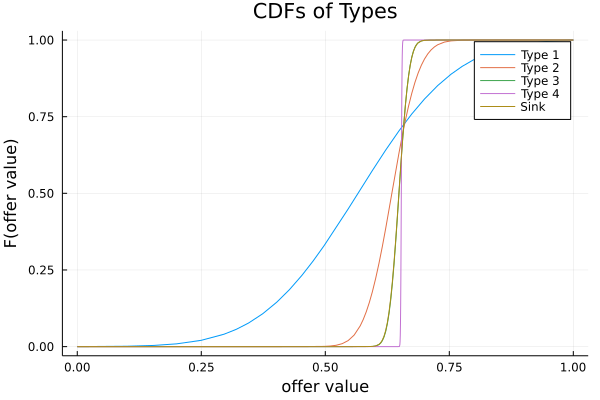

In [15]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/
select_type = 1
plot(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
select_type = 2
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = cdf, label = "Type 2")
select_type = 3
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = cdf, label = "Type 3")
select_type = 4
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = cdf, label = "Type 4")
select_type = 5 # the sink
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = cdf, label = "Sink")
xlabel!("offer value")
ylabel!("F(offer value)")

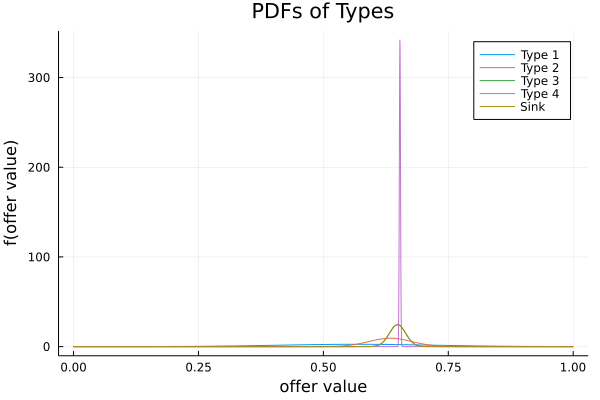

In [16]:
select_type = 1
plot(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
select_type = 2
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Type 2")
select_type = 3
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Type 3")
select_type = 4
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Type 4")
select_type = 5 # the sink
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Sink")
xlabel!("offer value")
ylabel!("f(offer value)")

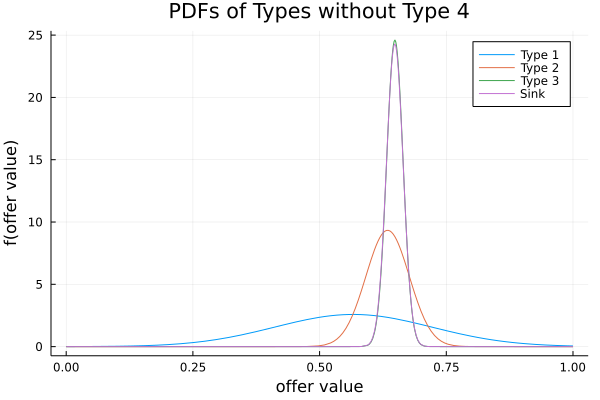

In [17]:
select_type = 1
plot(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, title = "PDFs of Types without Type 4", label = "Type 1")
select_type = 2
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Type 2")
select_type = 3
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Type 3")
select_type = 5 # the sink
plot!(TruncatedNormal(sol[3+select_type], sol[3+select_type+5], 0, 1), func = pdf, label = "Sink")
xlabel!("offer value")
ylabel!("f(offer value)")